# Head Pose Estimator (Gluon)

Tatsuya J. Arai @araitats
02/28/2018


## Introduction

In this notebook, the details of construction of convolutional neural network based head pose estimator are described. 

## Overview 

When there is a face photo presented in front of you, your human eyes can immediately recognize what direction the person in the photo is looking at (e.g. either facing straight up to the camera or looking at somewhere else).  The direction is defined as the head pose. A convolutional neural network model is trained with thousands of such face photos and their corresponding head pose labels, the model will be able to estimate various head poses when a new batch of face images are presented. In this notebook, the head pose is categorized into nine classes (i.e. the combinations of looking down, straight, and up (tilt angles) and looking right, middle and left (pan angles)).
    
## Modules

In [2]:
import os
import sys
import numpy as np
import cv2

import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import mxnet as mx
## Python version
print(sys.version)

2.7.12 (default, Nov 20 2017, 18:23:56) 
[GCC 5.4.0 20160609]


2.7.12 (default, Nov 20 2017, 18:23:56)  [GCC 5.4.0 20160609]

In [4]:
print(mx.__version__)

1.1.0


1.1.0

## Helper function

### Color shift in HSV space  

``shiftHSV`` shifts colors in a randomly selected input image.  

In [5]:
def shiftHSV(im, h_shift_lim=(-180, 180),
                 s_shift_lim=(-255, 255),
                 v_shift_lim=(-255, 255), drop_p=0.5):
    if np.random.random() < drop_p:
        im = cv2.cvtColor(im, cv2.COLOR_BGR2HSV)
        h, s, v = cv2.split(im)
        h_shift = np.random.uniform(h_shift_lim[0], h_shift_lim[1])
        h = cv2.add(h, h_shift) 
        s_shift = np.random.uniform(s_shift_lim[0], s_shift_lim[1])
        s = cv2.add(s, s_shift)
        v_shift = np.random.uniform(v_shift_lim[0], v_shift_lim[1])
        v = cv2.add(v, v_shift)
        im = cv2.merge((h, s, v))
        im = cv2.cvtColor(im, cv2.COLOR_HSV2BGR)
        im = np.uint8(im) 
        im = np.float32(im)
    return im

### Obtain a pre-trained ResNet Model from model zoo

In [6]:
from mxnet.gluon.model_zoo.vision import resnet50_v1
pretrained_net = resnet50_v1(pretrained=True, prefix = 'headpose_')
print(pretrained_net)

ResNetV1(
  (features): HybridSequential(
    (0): Conv2D(3 -> 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm(fix_gamma=False, use_global_stats=False, eps=1e-05, momentum=0.9, axis=1, in_channels=64)
    (2): Activation(relu)
    (3): MaxPool2D(size=(3, 3), stride=(2, 2), padding=(1, 1), ceil_mode=False)
    (4): HybridSequential(
      (0): BottleneckV1(
        (body): HybridSequential(
          (0): Conv2D(64 -> 64, kernel_size=(1, 1), stride=(1, 1))
          (1): BatchNorm(fix_gamma=False, use_global_stats=False, eps=1e-05, momentum=0.9, axis=1, in_channels=64)
          (2): Activation(relu)
          (3): Conv2D(64 -> 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (4): BatchNorm(fix_gamma=False, use_global_stats=False, eps=1e-05, momentum=0.9, axis=1, in_channels=64)
          (5): Activation(relu)
          (6): Conv2D(64 -> 256, kernel_size=(1, 1), stride=(1, 1))
          (7): BatchNorm(fix_gamma=False, use

## Load preprocessed datasets
### Dataset 


Original Data: http://www-prima.inrialpes.fr/perso/Gourier/Faces/HPDatabase.html

> N. Gourier, D. Hall, J. L. Crowley,
> Estimating Face Orientation from Robust Detection of Salient Facial Features,
> *Proceedings of Pointing 2004, ICPR, International Workshop on Visual Observation of Deictic Gestures*, Cambridge, UK

You have to preprocess the dataset using ``preprocessingDataset_py2.py``. This may take some time. 

> python2 preprocessingDataset_py2.py --num-data-aug 15 --aspect-ratio 1

Preprocessed Data: (6.7 GB (Aspect Ratio, 1:1) or 5.0 GB (Aspect Ratio, 16:9))

In [8]:
import pickle
trn_im, test_im, trn_output, test_output = pickle.load(open( "HeadPoseData_trn_test_x15_py2.pkl", "rb" ))

In [9]:
print(trn_im.shape, test_im.shape)
print(trn_output.shape, test_output.shape)

((33480, 3, 84, 84), (1674, 3, 84, 84))
((33480, 2), (1674, 2))


## Classification of Head Pose

### Make mirror images (data augmentation)

Head-pose images were flipped along the horizontal axis and the signs of corresponding head-pose pan angles were changed accordingly. The mirror image procedure effectively doubles the size of training data. 

In [10]:
trn_im_mirror = trn_im[:,:,:,::-1]
trn_output_mirror = np.zeros(trn_output.shape)
# Tilt
trn_output_mirror[:,0] = trn_output[:,0] 
# Pan
trn_output_mirror[:,1] = trn_output[:,1] * -1

In [11]:
im_idx = 200
print(trn_output[im_idx,:], trn_output_mirror[im_idx,:]) 

(array([-0.33333334, -1.        ], dtype=float32), array([-0.33333334,  1.        ]))


In [12]:
trn_im = np.concatenate((trn_im, trn_im_mirror), axis = 0) 
trn_output = np.concatenate((trn_output, trn_output_mirror), axis = 0)

In [13]:
print(trn_im.shape, trn_output.shape)

((66960, 3, 84, 84), (66960, 2))


### From (normalized) angles to angle classes (Tilts and Pans)

xxx_output[:,0] and xxx_output[i0,1] contain normalized agnle data (from -90 degrees to 90 degrees -> from -1.0 to 1.0) in tilt and pan directions, respectively. This process is to convert the normalized angle into one of three angle classes in each direction. 

In [14]:
n_grid = 3
angles_thrshld = [np.arcsin(float(a) * 2 / n_grid - 1)/np.pi * 180 / 90 for a in range(1,n_grid)]
print("Threshold Angles " +  (', ').join(["{:.2f}".format(a * 90) for a in angles_thrshld]))

Threshold Angles -19.47, 19.47


Head pose is classified into 9 categories (the combinations of 3 tilt and 3 pan classes). The head pose contained within +/- 19.5 degrees in tilt and pan angles is labeled as a center position (i.e. Grid Class of 4, Tilt Class of 1 and Pan Class of 1). The threshold angles, +/- 19.5 degrees split a semicircle (i.e. the distance between sin(-90 degrees) and sin(90 degrees)) into three equal arch lengths.

In [15]:
def angles2Cat(angles_thrshld, angl_input):
    # angl_input: Normalized angle -90 - 90 -> -1.0 - 1.0
    angles_cat_temp = angles_thrshld + [angl_input]
    return np.argmin(np.multiply(sorted(angles_cat_temp)-angl_input,sorted(angles_cat_temp)-angl_input))

### Dataset ###
trn_tilt_cls = []
trn_pan_cls = []
for i0 in range(trn_output.shape[0]):
    trn_tilt_cls += [angles2Cat(angles_thrshld, trn_output[i0,0])]
    trn_pan_cls += [angles2Cat(angles_thrshld, trn_output[i0,1])]

test_tilt_cls = []
test_pan_cls = []
for i0 in range(test_output.shape[0]):
    test_tilt_cls += [angles2Cat(angles_thrshld, test_output[i0,0])]
    test_pan_cls += [angles2Cat(angles_thrshld, test_output[i0,1])]

    
np_trn_tilt_cls = np.asarray(trn_tilt_cls)
np_test_tilt_cls = np.asarray(test_tilt_cls)
np_trn_pan_cls = np.asarray(trn_pan_cls)
np_test_pan_cls = np.asarray(test_pan_cls)


### From angles classes to 9 head pose classes

In [16]:
np_trn_grid_cls = np_trn_pan_cls * n_grid + np_trn_tilt_cls
np_test_grid_cls = np_test_pan_cls * n_grid + np_test_tilt_cls

print(np_trn_grid_cls.shape, np_trn_grid_cls.shape)

((66960,), (66960,))


### Shift colors in the training data (additional data augmentation)

The color shift procedure would simulate the changes in the lighting condition, skin tone, and background.

In [17]:
for i0 in range(trn_im.shape[0]):
    im_temp = trn_im[i0,:,:,:]
    im_temp = np.transpose(im_temp, (1,2,0)) * 255 #transposing and restoring the color
    im_temp = shiftHSV(im_temp,
                       h_shift_lim=(-0.1, 0.1),
                       s_shift_lim=(-0.1, 0.1),
                       v_shift_lim=(-0.1, 0.1))
    im_temp = np.transpose(im_temp, (2,0,1)) / 255 #transposing and restoring the color
    trn_im[i0,:,:,:] = im_temp

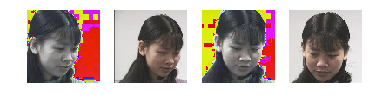

In [18]:
im_idx = 390
n_panels = 4
for i in range(n_panels):
    i0 = i + im_idx
    plt.subplot(1,n_panels,i+1)
    im_temp = trn_im[i0,:,:,:]
    im_temp = np.transpose(im_temp, (1,2,0))
    ## BGR -> RGB 
    plt.imshow(im_temp[:,:,[2,1,0]])
    plt.axis('off')

## Train the model

### Modify the ResNet 50 model from model zoo 

The number of output classes is modified to 9 to match our data.

In [20]:
net = resnet50_v1(classes=9, prefix='headpose_')
net.collect_params().initialize()
net.features = pretrained_net.features
from mxnet import init
#net.output.initialize(init.Xavier(rnd_type='gaussian', factor_type="in", magnitude=2)) # MXNet 1.1.0
net.initialize(init.Xavier(rnd_type='gaussian', factor_type="in", magnitude=2)) # MXNet 0.12.1
print(net)

ResNetV1(
  (features): HybridSequential(
    (0): Conv2D(3 -> 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm(fix_gamma=False, use_global_stats=False, eps=1e-05, momentum=0.9, axis=1, in_channels=64)
    (2): Activation(relu)
    (3): MaxPool2D(size=(3, 3), stride=(2, 2), padding=(1, 1), ceil_mode=False)
    (4): HybridSequential(
      (0): BottleneckV1(
        (body): HybridSequential(
          (0): Conv2D(64 -> 64, kernel_size=(1, 1), stride=(1, 1))
          (1): BatchNorm(fix_gamma=False, use_global_stats=False, eps=1e-05, momentum=0.9, axis=1, in_channels=64)
          (2): Activation(relu)
          (3): Conv2D(64 -> 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (4): BatchNorm(fix_gamma=False, use_global_stats=False, eps=1e-05, momentum=0.9, axis=1, in_channels=64)
          (5): Activation(relu)
          (6): Conv2D(64 -> 256, kernel_size=(1, 1), stride=(1, 1))
          (7): BatchNorm(fix_gamma=False, use

### Training Helper Functions

In [25]:
from mxnet import autograd
from mxnet import nd

# Accuracy Evaluation
def eval_acc(data_iter, net, ctx):
    acc = mx.metric.Accuracy()
    for i, (data, label) in enumerate(data_iter):
        data = data.as_in_context(ctx)
        label = label.as_in_context(ctx)

        output = net(data)
        pred = nd.argmax(output, axis=1)
        acc.update(preds=pred, labels=label)
    return acc.get()[1]

# Training Loop
def train_util(net, train_iter, validation_iter, loss_fn, trainer, ctx, epochs, batch_size):
    metric = mx.metric.create(['acc'])
    lst_val_acc = []
    lst_trn_acc = []
    best_accuracy = 0
    for epoch in range(epochs):
        for i, (data, label) in enumerate(train_iter):
            # ensure context            
            data = data.as_in_context(ctx)
            label = label.as_in_context(ctx)
            
            with autograd.record():
                output = net(data)
                loss = loss_fn(output, label)

            loss.backward()
            trainer.step(data.shape[0])

        train_acc = eval_acc(train_iter, net, ctx)
        validation_acc = eval_acc(validation_iter, net, ctx)

        lst_trn_acc += [train_acc]
        lst_val_acc += [validation_acc]
                
        ### Save checkpoint weights
        #
        # We save the model in the symbolic format (i.e. XXX.json and XXX.params)
        #
        
        # Export .json and .params files
        # chkpt-XX-symbol.json does not come with softmax layer at the end. 
        net.export('chkpt-{}'.format(epoch)) 
        # Overwrite .json with the one with softmax
        net_with_softmax = net(mx.sym.var('data'))
        net_with_softmax = mx.sym.SoftmaxOutput(data=net_with_softmax, name="softmax")
        net_with_softmax.save('chkpt-{}-symbol.json'.format(epoch)) 
        print("Epoch %s | training_acc %s | val_acc %s " % (epoch, train_acc, validation_acc))
        
        if validation_acc > best_accuracy:
            # A network with the best validation accuracy is returned.  
            net_best = net
            net_with_softmax_best = net_with_softmax
            best_accuracy = validation_acc
        
    return lst_trn_acc, lst_val_acc, net_best

### Fine-tune the model

We run the training. 

In [26]:
def train(net, ctx, batch_size=64, epochs=10, learning_rate=0.0005):
    # Making Gluon iterators
    train_iter = mx.gluon.data.DataLoader(mx.gluon.data.ArrayDataset((trn_im.astype(np.float32)-0.5) *2, np_trn_grid_cls),
                                                batch_size=batch_size, shuffle=True, last_batch='discard')
    test_iter = mx.gluon.data.DataLoader(mx.gluon.data.ArrayDataset((test_im.astype(np.float32)-0.5) *2 , np_test_grid_cls),
                                                batch_size=batch_size, shuffle=True, last_batch='discard')

    net.collect_params().reset_ctx(ctx)
    net.hybridize()
    
    loss = gluon.loss.SoftmaxCrossEntropyLoss()
    trainer = gluon.Trainer(net.collect_params(), 'adam', {'learning_rate': learning_rate})
    
    return train_util(net, train_iter, test_iter, loss, trainer, ctx, epochs, batch_size)

In [27]:
from mxnet import gluon
import mxnet as mx
ctx = mx.gpu()
lst_trn_acc, lst_val_acc, net_gluon = train(net, ctx, batch_size=64, epochs=5, learning_rate=0.0005)

Epoch 0 | training_acc 0.97866873805 | val_acc 0.795673076923 
Epoch 1 | training_acc 0.979953393881 | val_acc 0.798677884615 
Epoch 2 | training_acc 0.985316085086 | val_acc 0.783052884615 
Epoch 3 | training_acc 0.988363408222 | val_acc 0.795072115385 
Epoch 4 | training_acc 0.987258006692 | val_acc 0.785456730769 


### Save the model in the serial (Gluon) format

We can also save the model in the serial (Gluon) format. 

In [28]:
'''
Save net (Gluon model) in the serial format  -> Pass the weights to another serialized model. 
'''

net_gluon.save_params('net_gluon.params')
net_gluon2 = resnet50_v1(classes=9, prefix='headpose_')
net_gluon2.load_params('net_gluon.params', ctx=mx.cpu())

### Learning Curve

The plot shows the changes in validation accuracy during the trining. 

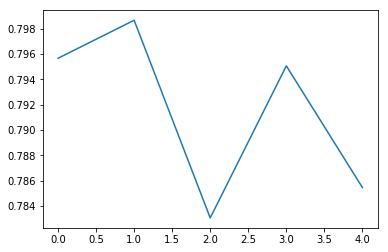

In [29]:
plt.plot(lst_val_acc)

## Take a peek at validation results

Let's load a model and make inference results of validation data.  

### Make iterators for the modular model artifact from nparrays

In [30]:
batch_size = 300

trn_iter_grid = mx.io.NDArrayIter((trn_im.astype(np.float32) -0.5) * 2, np_trn_grid_cls, batch_size, shuffle=True)
test_iter_grid = mx.io.NDArrayIter((test_im.astype(np.float32)-0.5) * 2, np_test_grid_cls, batch_size)

### Load modular model

In [46]:
def load_model(s_fname, p_fname):
    """
    Load model checkpoint from file.
    :return: (arg_params, aux_params)
    arg_params : dict of str to NDArray
        Model parameter, dict of name to NDArray of net's weights.
    aux_params : dict of str to NDArray
        Model parameter, dict of name to NDArray of net's auxiliary states.
    """
    symbol = mx.symbol.load(s_fname)
    save_dict = mx.nd.load(p_fname)
    arg_params = {}
    aux_params = {}
    for k, v in save_dict.items():
        tp, name = k.split(':', 1)
        if tp == 'arg':
            arg_params[name] = v
        if tp == 'aux':
            aux_params[name] = v
    return symbol, arg_params, aux_params

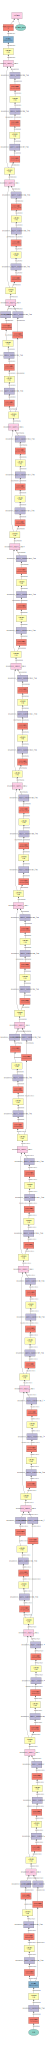

In [31]:
model_symbol = 'chkpt-3-symbol.json'
model_params = 'chkpt-3-0000.params'

sym, arg_params, aux_params = load_model(model_symbol, model_params)

ctx = [mx.gpu(i) for i in range(4)] # USE GPU to look up validation results 
net2 = mx.mod.Module(symbol=sym,context=ctx)

shape = {"data": (batch_size, trn_im.shape[1], trn_im.shape[2], trn_im.shape[3])}
mx.viz.plot_network(sym, shape=shape)

### You may notice that Gluon-ResNet-50 does not have a batch norm layer right after the input layer. 

In [32]:
net2.bind(data_shapes=[trn_iter_grid.provide_data[0]], label_shapes=[trn_iter_grid.provide_label[0]])
net2.set_params(arg_params, aux_params)

### Infer validation data iterator

In [33]:
preds = net2.predict(test_iter_grid).asnumpy()
print(preds.shape)
### Head Pose Prediction (9 classes)
pred_cls = []

for idx in range(preds.shape[0]):
    pred_cls += [int(preds[idx].argmax())]

### Tilt Prediction (3 classes)
pred_tilt = pred_cls % max(np_trn_tilt_cls + 1)
### Pan Prediction (3 classes)
pred_pan = pred_cls // max(np_trn_tilt_cls + 1) 

(1674, 9)


## Confusion matrix

Confusion matrix is one of the useful ways to visualize the validation accuracy. 

In [34]:
from sklearn.metrics import confusion_matrix

lst_angl_lbl = ['<< -19.5 dgrs', '-19.5 to 19.5 dgrs', '>> 19.5 dgrs']
lst_angl_lbl_tilt = ['<< -19.5 dgrs (Down)', '-19.5 to 19.5 dgrs', '>> 19.5 dgrs (Up)']
lst_angl_lbl_pan = ['<< -19.5 dgrs (Your Right)', '-19.5 to 19.5 dgrs', '>> 19.5 dgrs (Your Left)']

cm_grid = confusion_matrix(y_true=np_test_grid_cls,  # True class for test-set.
                      y_pred=pred_cls)  # Predicted class.

cm_tilt = confusion_matrix(y_true=np_test_tilt_cls,  # True class for test-set.
                      y_pred=pred_tilt)  # Predicted class.

cm_pan = confusion_matrix(y_true=np_test_pan_cls,  # True class for test-set.
                      y_pred=pred_pan)  # Predicted class.

### Confusion matrix helper function

In [35]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.3f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

## Head pose prediction in the 9 classes
### Confusion matrix

Confusion matrix, without normalization
[[144  30   0   6   0   0   0   0   0]
 [ 18 201  45   0   4   2   0   0   0]
 [  0   4 161   0   0  15   0   0   0]
 [  2   0   0 111   2   0  11   0   0]
 [  0   1   0  13 108  30   3   5   2]
 [  0   0   1   0  14 102   0   0   9]
 [  0   0   0   6   0   0 149  25   0]
 [  0   0   0   0   4   0  29 196  41]
 [  0   0   0   0   0   3   0  19 158]]


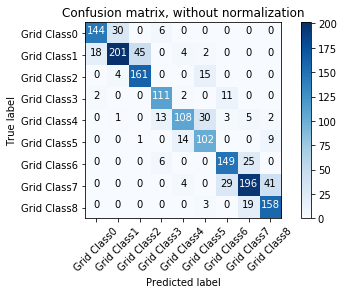

In [36]:
# Compute confusion matrix Head Pose 
cnf_matrix = cm_grid
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=["Grid Class" + str(i) for i in range(max(np_trn_grid_cls + 1))],
                      title='Confusion matrix, without normalization')

plt.rc('figure', figsize=(10.0, 5.0))

### Normalized confusion matrix

Normalized confusion matrix
[[ 0.8   0.17  0.    0.03  0.    0.    0.    0.    0.  ]
 [ 0.07  0.74  0.17  0.    0.01  0.01  0.    0.    0.  ]
 [ 0.    0.02  0.89  0.    0.    0.08  0.    0.    0.  ]
 [ 0.02  0.    0.    0.88  0.02  0.    0.09  0.    0.  ]
 [ 0.    0.01  0.    0.08  0.67  0.19  0.02  0.03  0.01]
 [ 0.    0.    0.01  0.    0.11  0.81  0.    0.    0.07]
 [ 0.    0.    0.    0.03  0.    0.    0.83  0.14  0.  ]
 [ 0.    0.    0.    0.    0.01  0.    0.11  0.73  0.15]
 [ 0.    0.    0.    0.    0.    0.02  0.    0.11  0.88]]


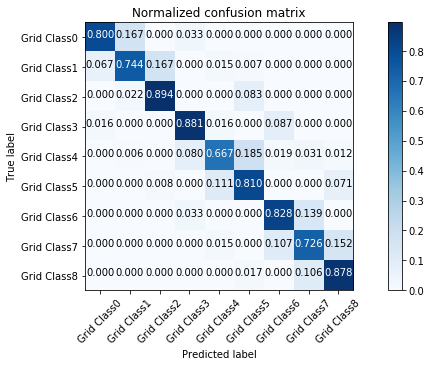

In [37]:
# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=["Grid Class" + str(i) for i in range(9)], normalize=True,
                      title='Normalized confusion matrix')

plt.rc('figure', figsize=(10.0, 5.0))

## Head pose prediction in Tilt (Pitch)

Confusion matrix, without normalization
[[429  57   0]
 [ 63 519 120]
 [  0  37 449]]
Normalized confusion matrix
[[ 0.883  0.117  0.   ]
 [ 0.09   0.739  0.171]
 [ 0.     0.076  0.924]]


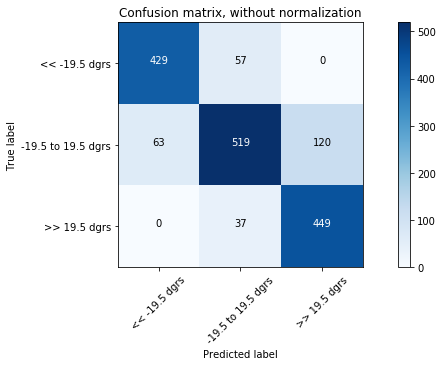

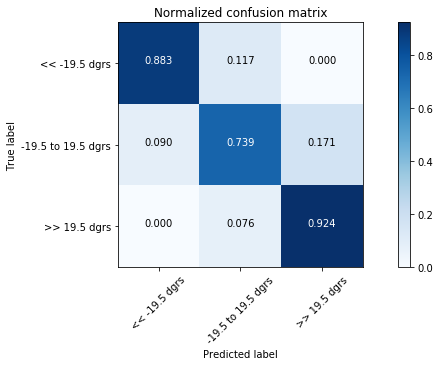

In [38]:
# Compute confusion matrix Tilt (Pitch)
cnf_matrix = cm_tilt
np.set_printoptions(precision=3)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=lst_angl_lbl,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=lst_angl_lbl, normalize=True,
                      title='Normalized confusion matrix')

plt.rc('figure', figsize=(5.0, 4.0))

## Head pose prediction in Pan (Yaw)

Confusion matrix, without normalization
[[603  27   0]
 [  4 380  30]
 [  0  13 617]]
Normalized confusion matrix
[[ 0.957  0.043  0.   ]
 [ 0.01   0.918  0.072]
 [ 0.     0.021  0.979]]


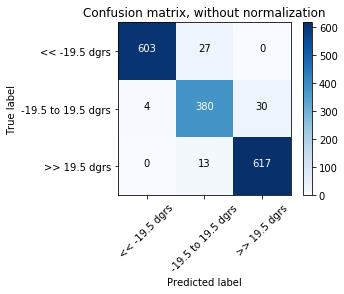

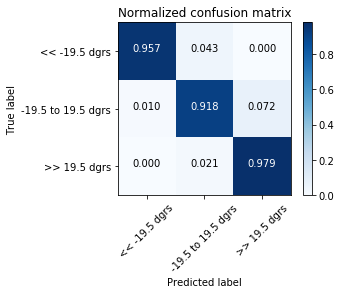

In [39]:
# Compute confusion matrix Pan (Yaw)
cnf_matrix = cm_pan
np.set_printoptions(precision=3)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=lst_angl_lbl,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=lst_angl_lbl, normalize=True,
                      title='Normalized confusion matrix')

plt.rc('figure', figsize=(5.0, 4.0))

## Prediction accuracy

In [40]:
i_test_count = 0

for idx in range(np_test_tilt_cls.shape[0]):
    if abs(np_test_tilt_cls[idx] - pred_tilt[idx]) + abs(np_test_pan_cls[idx] - pred_pan[idx]) >= 1:
        i_test_count += 1

print("The number of false predictions: {}".format(i_test_count))
print("Validation Accuracy: {:.3f}".format(1 - float(i_test_count)/np_test_tilt_cls.shape[0]))

The number of false predictions: 344
Validation Accuracy: 0.795


## Inference

### Predict a head pose of an arbitrary image

In [41]:
dshape = [('data', (1,trn_im.shape[1], trn_im.shape[2], trn_im.shape[3]))]

ctx = mx.cpu() # USE CPU to predict... 
net2 = mx.mod.Module(symbol=sym,context=ctx)
net2.bind(for_training=False, data_shapes=dshape)
net2.set_params(arg_params, aux_params)

/usr/local/lib/python2.7/dist-packages/mxnet/module/base_module.py:65: UserWarning: Data provided by label_shapes don't match names specified by label_names ([] vs. ['softmax_label'])
  warnings.warn(msg)


### Load, crop, and resize a head image 

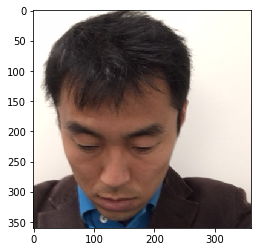

(360, 360, 3)


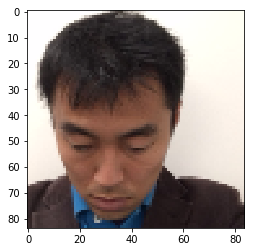

(84, 84, 3)
(-0.97647058823529409, 1.0)


In [42]:
###
im = cv2.imread("testIMs/" + "IMG_1247.JPG")
im_true = im.copy()

if trn_im.shape[2] == trn_im.shape[3]:
    ### Aspect Ratio 1:1
    crop_uly = 62
    crop_height = 360
    crop_ulx = 100
    crop_width = 360
    im = im[crop_uly:crop_uly + crop_height, crop_ulx:crop_ulx + crop_width]
    im_crop = im.copy()
    plt.imshow(im_crop[:,:,::-1])
    plt.show()
    print(im.shape)

    im = cv2.resize(im, (trn_im.shape[3], trn_im.shape[2]))
    plt.imshow(im[:,:,::-1])
    plt.show()
    print(im.shape)
else:
    ### Aspect Ratio 16:9
    crop_uly = 62
    crop_height = 360
    crop_ulx = 0
    crop_width = 640
    im = im[crop_uly:crop_uly + crop_height, crop_ulx:crop_ulx + crop_width]
    im_crop = im.copy()
    plt.imshow(im_crop[:,:,::-1])
    plt.show()
    print(im.shape)

    im = cv2.resize(im, (trn_im.shape[3], trn_im.shape[2]))
    plt.imshow(im[:,:,::-1])
    plt.show()
    print(im.shape)
    
im = np.swapaxes(im, 0, 2)
im = np.swapaxes(im, 1, 2)
im = (im[np.newaxis, :] / 255.0 - 0.5) * 2
print(np.min(im), np.max(im))

In [43]:
print(im.shape)

(1, 3, 84, 84)


### Predict a head pose

In [44]:
from collections import namedtuple
Batch = namedtuple('Batch', ['data'])
net2.forward(Batch([mx.nd.array(im)]))
prob = net2.get_outputs()[0].asnumpy()
pred = prob.argmax()
print(prob)
print("Predicted Class: {}, {:.1f}%".format(pred, prob[0][pred] * 100))

[[  1.131e-05   1.212e-08   3.173e-08   1.000e+00   9.886e-07   6.803e-08
    9.365e-07   1.450e-08   9.858e-09]]
Predicted Class: 3, 100.0%


### Display a head pose

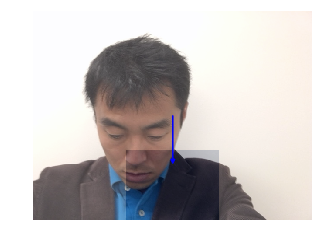

In [45]:
n_grid_cls = 9
n_tilt_cls = 3

### Tilt Prediction
pred_tilt_pic = pred % n_tilt_cls
### Pan Prediction
pred_pan_pic = pred // n_tilt_cls

extent = 0, im_true.shape[1]-1, im_true.shape[0]-1, 0
Panel_Pred = np.zeros((n_tilt_cls, n_tilt_cls))
Panel_Pred[pred_tilt_pic, pred_pan_pic] = 1
Panel_Pred = np.fliplr(Panel_Pred)
Panel_Pred = np.flipud(Panel_Pred)
plt.imshow(im_true[:,:,[2,1,0]], extent=extent)
plt.imshow(Panel_Pred, cmap=plt.cm.Blues, alpha=.2, interpolation='nearest', extent=extent)
plt.axis('off')
arrw_mg = 100
arrw_x_rad = 1 * (prob[0][0] + prob[0][1] + prob[0][2] - prob[0][6] -prob[0][7] - prob[0][8]) * 90 * np.pi / 180. 
arrw_y_rad = 1 * (prob[0][0] + prob[0][3] + prob[0][6] - prob[0][2] -prob[0][5] - prob[0][8]) * 90 * np.pi / 180.
plt.arrow(im_true.shape[1]//2, im_true.shape[0]//2, 
          np.sin(arrw_x_rad) * arrw_mg, np.sin(arrw_y_rad) * arrw_mg, 
          head_width=10, head_length=10, fc='b', ec='b')
plt.show()

## End